# Machine Learning Models

In this notebook we will use the data available to make sentiment analysis and predictive models around the satisfaction of the clients according to the use of the E-Commerce and the reviews of the purchases in order to improve the UX by the ofert available at the Marketplace.

**References:**
- [NLP](https://www.kaggle.com/code/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp)
- [Customer Satisfaction Prediction](https://www.kaggle.com/code/khakim17/custumer-satisfaction-prediction-and-analysist)

In [1]:
!pip install nltk sklearn joblib

  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached scikit_learn-1.1.1-cp310-cp310-win_amd64.whl (7.3 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)


You should consider upgrading via the 'D:\Documentos\Clases\Platzi\Escuela DS\Django\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# DataPrep
import re
import nltk
nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.data import load
from nltk.stem.api import StemmerI


#Model Training
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

[nltk_data] Downloading package rslp to /home/alexrods/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [3]:
reviews_df = pd.read_csv('datasets/order_reviews.csv')

In [4]:
df_comments = reviews_df.loc[:, ['review_score', 'review_comment_message']]
df_comments = df_comments.dropna(subset=['review_comment_message'])
df_comments = df_comments.reset_index(drop=True)
print(f'Dataset shape: {df_comments.shape}')
df_comments.columns = ['score', 'comment']
df_comments.head()

Dataset shape: (40977, 2)


,score,comment
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente. no site a marca do aparelh...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\n"
4,5,"Vendedor confiável, produto ok e entrega antes..."


## Cleaning the reviews with RegEx

### Creating the Stemmer

In [5]:
class RSLPStemmer(StemmerI):
    """
    A stemmer for Portuguese.

        >>> from nltk.stem import RSLPStemmer
        >>> st = RSLPStemmer()
        >>> # opening lines of Erico Verissimo's "Música ao Longe"
        >>> text = '''
        ... Clarissa risca com giz no quadro-negro a paisagem que os alunos
        ... devem copiar . Uma casinha de porta e janela , em cima duma
        ... coxilha .'''
        >>> for token in text.split():
        ...     print(st.stem(token))
        clariss risc com giz no quadro-negr a pais que os alun dev copi .
        uma cas de port e janel , em cim dum coxilh .
    """

    def __init__(self):
        self._model = []

        self._model.append(self.read_rule("step0.pt"))
        self._model.append(self.read_rule("step1.pt"))
        self._model.append(self.read_rule("step2.pt"))
        self._model.append(self.read_rule("step3.pt"))
        self._model.append(self.read_rule("step4.pt"))
        self._model.append(self.read_rule("step5.pt"))
        self._model.append(self.read_rule("step6.pt"))


    def read_rule(self, filename):
        rules = load("nltk:stemmers/rslp/" + filename, format="raw").decode("utf8")
        lines = rules.split("\n")

        lines = [line for line in lines if line != ""]  # remove blank lines
        lines = [line for line in lines if line[0] != "#"]  # remove comments

        # NOTE: a simple but ugly hack to make this parser happy with double '\t's
        lines = [line.replace("\t\t", "\t") for line in lines]

        # parse rules
        rules = []
        for line in lines:
            rule = []
            tokens = line.split("\t")

            # text to be searched for at the end of the string
            rule.append(tokens[0][1:-1])  # remove quotes

            # minimum stem size to perform the replacement
            rule.append(int(tokens[1]))

            # text to be replaced into
            rule.append(tokens[2][1:-1])  # remove quotes

            # exceptions to this rule
            rule.append([token[1:-1] for token in tokens[3].split(",")])

            # append to the results
            rules.append(rule)

        return rules


    def stem(self, word):
        word = word.lower()

        # the word ends in 's'? apply rule for plural reduction
        if word[-1] == "s":
            word = self.apply_rule(word, 0)

        # the word ends in 'a'? apply rule for feminine reduction
        if word[-1] == "a":
            word = self.apply_rule(word, 1)

        # augmentative reduction
        word = self.apply_rule(word, 3)

        # adverb reduction
        word = self.apply_rule(word, 2)

        # noun reduction
        prev_word = word
        word = self.apply_rule(word, 4)
        if word == prev_word:
            # verb reduction
            prev_word = word
            word = self.apply_rule(word, 5)
            if word == prev_word:
                # vowel removal
                word = self.apply_rule(word, 6)

        return word


    def apply_rule(self, word, rule_index):
        rules = self._model[rule_index]
        for rule in rules:
            suffix_length = len(rule[0])
            if word[-suffix_length:] == rule[0]:  # if suffix matches
                if len(word) >= suffix_length + rule[1]:  # if we have minimum size
                    if word not in rule[3]:  # if not an exception
                        word = word[:-suffix_length] + rule[2]
                        break

        return word

### Functions to clean the data with RegEx

In [6]:
def print_step_result(df_before,df_after, idx_list):
    """
    Args:
    ----------
    df_before: dataframe before preprocessing [type: dataframe]
    df_after: dataframe after preprocessing [type: dataframe]
    idx_list: list with the index of dataframes to compare [type: list]
    """
    for i in idx_list:
        print(f'{i}')
        print(f'Before:\n{df_before[i]}')
        print(f'After:\n{df_after[i]}')
        print('\n')
def re_breakline(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('[\n\r]', ' ', r) for r in text_list]

def re_hiperlinks(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

def re_dates(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' date ', r) for r in text_list]

def re_money(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]

def re_numbers(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('[0-9]+', ' numero ', r) for r in text_list]

def re_negation(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]

def re_special_chars(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('\W', ' ', r) for r in text_list]

def re_whitespaces(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

# Defining a function to remove the stopwords and to lower the comments
def stopwords_removal(text, cached_stopwords=stopwords.words('portuguese')):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    cached_stopwords: stopwords to be applied on the process [type: list, default: stopwords.words('portuguese')]
    """
    
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

# Defining a function to remove the stopwords and to lower the comments
def stemming_process(text, stemmer=RSLPStemmer()):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    stemmer: type of stemmer to be applied [type: class, default: RSLPStemmer()]
    """
    
    return [stemmer.stem(c) for c in text.split()]

### Corpus Features Extraction

In [7]:
def extract_features_from_corpus(corpus, vectorizer, df=False):
    """
    Args
    ------------
    text: text to be transformed into a document-term matrix [type: string]
    vectorizer: engine to be used in the transformation [type: object]
    """

    # Extracting features
    corpus_features = vectorizer.fit_transform(corpus).toarray()
    features_names = vectorizer.get_feature_names()

    # Transforming into a dataframe to give interpetability to the process
    df_corpus_features = None
    if df:
        df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)

    return corpus_features, df_corpus_features

### Text Viz

In [8]:
def format_spines(ax, right_border=True):
    """
    This function sets up borders from an axis and personalize colors

    Input:
        Axis and a flag for deciding or not to plot the right border
    Returns:
        Plot configuration
    """
    # Setting up colors
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#CCCCCC')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')

# Classe para plotagem dos rótulos dos dados em gráficos de barras
# Referência: https://towardsdatascience.com/annotating-bar-charts-and-other-matplolib-techniques-cecb54315015
#Alias types to reduce typing, no pun intended

#Patch = matplotlib.patches.Patch
#PosVal = Tuple[float, Tuple[float, float]]
#Axis = matplotlib.axes.Axes
#PosValFunc = Callable[[Patch], PosVal]

def single_countplot(df, ax, x=None, y=None, top=None, order=True, hue=False, palette='plasma',
                     width=0.75, sub_width=0.3, sub_size=12):
    """
    Parâmetros
    ----------
    classifiers: conjunto de classificadores em forma de dicionário [dict]
    X: array com os dados a serem utilizados no treinamento [np.array]
    y: array com o vetor target do modelo [np.array]

    Retorno
    -------
    None
    """

    # Verificando plotagem por quebra de alguma variável categórica
    ncount = len(df)
    if x:
        col = x
    else:
        col = y

    # Verificando a plotagem de top categorias
    if top is not None:
        cat_count = df[col].value_counts()
        top_categories = cat_count[:top].index
        df = df[df[col].isin(top_categories)]

    # Validando demais argumentos e plotando gráfico
    if hue != False:
        if order:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, order=df[col].value_counts().index, hue=hue)
        else:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, hue=hue)
    else:
        if order:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, order=df[col].value_counts().index)
        else:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax)

    # Formatando eixos
    format_spines(ax, right_border=False)

    # Inserindo rótulo de percentual
    if x:
        for p in ax.patches:
            x = p.get_bbox().get_points()[:, 0]
            y = p.get_bbox().get_points()[1, 1]
            ax.annotate('{}\n{:.1f}%'.format(int(y), 100. * y / ncount), (x.mean(), y), ha='center', va='bottom')
    else:
        for p in ax.patches:
            x = p.get_bbox().get_points()[1, 0]
            y = p.get_bbox().get_points()[:, 1]
            ax.annotate('{} ({:.1f}%)'.format(int(x), 100. * x / ncount), (x, y.mean()), va='center')


def donut_plot(df, col, ax, label_names=None, text='', colors=['crimson', 'navy'], circle_radius=0.8,
            title=f'Donut Chart', flag_ruido=0):
    """
    Etapas:
        1. definição de funções úteis para mostrar rótulos em valor absoluto e porcentagem
        2. criação de figura e círculo central de raio pré-definido
        3. plotagem do gráfico de pizza e adição do círculo central
        4. configuração final da plotagem

    Argumentos:
        df -- DataFrame alvo da análise [pandas.DataFrame]
        col -- coluna do DataFrame a ser analisada [string]
        label_names -- nomes customizados a serem plotados como labels [list]
        text -- texto central a ser posicionado [string / default: '']
        colors -- cores das entradas [list / default: ['crimson', 'navy']]
        figsize -- dimensões da plotagem [tupla / default: (8, 8)]
        circle_radius -- raio do círculo central [float / default: 0.8]

    Retorno:
        None
    """

    # Retorno dos valores e definição da figura
    values = df[col].value_counts().values
    if label_names is None:
        label_names = df[col].value_counts().index

    # Verificando parâmetro de supressão de alguma categoria da análise
    if flag_ruido > 0:
        values = values[:-flag_ruido]
        label_names = label_names[:-flag_ruido]

    # Plotando gráfico de rosca
    center_circle = plt.Circle((0, 0), circle_radius, color='white')
    ax.pie(values, labels=label_names, colors=colors, autopct=make_autopct(values))
    ax.add_artist(center_circle)

    # Configurando argumentos do texto central
    kwargs = dict(size=20, fontweight='bold', va='center')
    ax.text(0, 0, text, ha='center', **kwargs)
    ax.set_title(title, size=14, color='dimgrey')


def make_autopct(values):
    """
    Etapas:
        1. definição de função para formatação dos rótulos

    Argumentos:
        values -- valores extraídos da função value_counts() da coluna de análise [list]

    Retorno:
        my_autopct -- string formatada para plotagem dos rótulos
    """

    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))

        return '{p:.1f}%\n({v:d})'.format(p=pct, v=val)

    return my_autopct


def ngrams_count(corpus, ngram_range, n=-1, cached_stopwords=stopwords.words('portuguese')):
    """
    Args
    ----------
    corpus: text to be analysed [type: pd.DataFrame]
    ngram_range: type of n gram to be used on analysis [type: tuple]
    n: top limit of ngrams to be shown [type: int, default: -1]
    """

    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer(stop_words=cached_stopwords, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]

    # Returning a DataFrame with the ngrams count
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

### Data prep Pipeline

In [9]:
# [TEXT PREP] Classe para aplicar uma série de funções RegEx definidas em um dicionário
class ApplyRegex(BaseEstimator, TransformerMixin):

    def __init__(self, regex_transformers):
        self.regex_transformers = regex_transformers

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Applying all regex functions in the regex_transformers dictionary
        for regex_name, regex_function in self.regex_transformers.items():
            X = regex_function(X)

        return X


# [TEXT PREP] Classe para aplicar a remoção de stopwords em um corpus
class StopWordsRemoval(BaseEstimator, TransformerMixin):

    def __init__(self, text_stopwords):
        self.text_stopwords = text_stopwords

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [' '.join(stopwords_removal(comment, self.text_stopwords)) for comment in X]


# [TEXT PREP] Classe para aplicar o processo de stemming em um corpus
class StemmingProcess(BaseEstimator, TransformerMixin):

    def __init__(self, stemmer):
        self.stemmer = stemmer

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [' '.join(stemming_process(comment, self.stemmer)) for comment in X]


# [TEXT PREP] Classe para extração de features de um corpus (vocabulário / bag of words / TF-IDF)
class TextFeatureExtraction(BaseEstimator, TransformerMixin):

    def __init__(self, vectorizer, train=True):
        self.vectorizer = vectorizer
        self.train = train

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.train:
            return self.vectorizer.fit_transform(X).toarray()
        else:
            return self.vectorizer.transform(X)

### Utilities for sentiment analysis

In [10]:
# Defining a function to plot the sentiment of a given phrase
def sentiment_analysis(text, pipeline, vectorizer, model):
    """
    Args
    -----------
    text: text string / phrase / review comment to be analysed [type: string]
    pipeline: text prep pipeline built for preparing the corpus [type: sklearn.Pipeline]
    model: classification model trained to recognize positive and negative sentiment [type: model]
    """

    # Applying the pipeline
    if type(text) is not list:
        text = [text]
    text_prep = pipeline.fit_transform(text)
    matrix = vectorizer.transform(text_prep)

    # Predicting sentiment
    pred = model.predict(matrix)
    proba = model.predict_proba(matrix)

    # Plotting the sentiment and its score
    fig, ax = plt.subplots(figsize=(5, 3))
    if pred[0] == 1:
        text = 'Positive'
        class_proba = 100 * round(proba[0][1], 2)
        color = 'seagreen'
    else:
        text = 'Negative'
        class_proba = 100 * round(proba[0][0], 2)
        color = 'crimson'
    ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
    ax.text(0.5, 0.20, str(class_proba) + '%', fontsize=14, ha='center')
    ax.axis('off')
    ax.set_title('Sentiment Analysis', fontsize=14)
    plt.show()

### Cleaning process and results verification 

In [11]:
# Creating a list of comment reviews
reviews = list(df_comments['comment'].values)

reviews_breakline = re_breakline(reviews)
df_comments['re_breakline'] = reviews_breakline
# Verifying results
#print_step_result(reviews, reviews_breakline, idx_list=[48])

reviews_hiperlinks = re_hiperlinks(reviews_breakline)
df_comments['re_hiperlinks'] = reviews_hiperlinks
#print_step_result(reviews_breakline, reviews_hiperlinks, idx_list=[10607])

reviews_dates = re_dates(reviews_hiperlinks)
df_comments['re_dates'] = reviews_dates
# Verifying results
#print_step_result(reviews_hiperlinks, reviews_dates, idx_list=[26161, 40729, 40901])

reviews_money = re_money(reviews_dates)
df_comments['re_money'] = reviews_money
# Verifying results
#print_step_result(reviews_dates, reviews_money, idx_list=[25533, 32667, 32370])

reviews_numbers = re_numbers(reviews_money)
df_comments['re_numbers'] = reviews_numbers
# Verifying results
#print_step_result(reviews_money, reviews_numbers, idx_list=[68])

reviews_negation = re_negation(reviews_numbers)
df_comments['re_negation'] = reviews_negation
# Verifying results
#print_step_result(reviews_numbers, reviews_negation, idx_list=[4703, 4549, 4773, 4820])

reviews_special_chars = re_special_chars(reviews_negation)
df_comments['re_special_chars'] = reviews_special_chars
# Verifying results
#print_step_result(reviews_negation, reviews_special_chars, idx_list=[45, 1165, 17579])

reviews_whitespaces = re_whitespaces(reviews_special_chars)
df_comments['re_whitespaces'] = reviews_whitespaces
# Verifying results
#print_step_result(reviews_special_chars, reviews_whitespaces, idx_list=[66, 121, 5602])

reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces]
df_comments['stopwords_removed'] = reviews_stopwords
# Verifying results
#print_step_result(reviews_whitespaces, reviews_stopwords, idx_list=[108, 13646, 6563])

reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
df_comments['stemming'] = reviews_stemmer
# Verifying results
#print_step_result(reviews_stopwords, reviews_stemmer, idx_list=[0, 45, -1])


In [12]:
# this list comprehension helps us to check reviews with complex words to test the regex, returning a list of indexes
[reviews_hiperlinks.index(s) for s in reviews_hiperlinks if " 😡 " in s]

[29272]

### Labelling Data

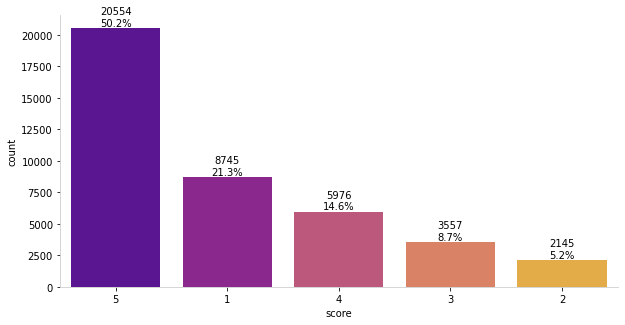

In [13]:
g, ax = plt.subplots(figsize=(10, 5))
single_countplot(x='score', df=df_comments, ax=ax)

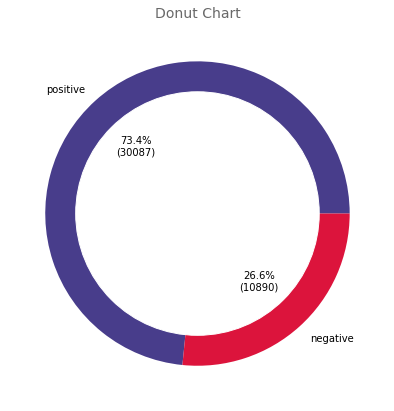

In [14]:
# Labelling data
score_map = {
    1: 'negative',
    2: 'negative',
    3: 'positive',
    4: 'positive',
    5: 'positive'
}
df_comments['sentiment_label'] = df_comments['score'].map(score_map)

# Verifying results
fig, ax = plt.subplots(figsize=(7, 7))
donut_plot(df_comments.query('sentiment_label in ("positive", "negative")'), 'sentiment_label', 
           label_names=df_comments.query('sentiment_label in ("positive", "negative")')['sentiment_label'].value_counts().index,
           ax=ax, colors=['darkslateblue', 'crimson'])

### n-grams Viz

In [15]:
def ngrams_count(corpus, ngram_range, n=-1, cached_stopwords=stopwords.words('portuguese')):
    """
    Args
    ----------
    corpus: text to be analysed [type: pd.DataFrame]
    ngram_range: type of n gram to be used on analysis [type: tuple]
    n: top limit of ngrams to be shown [type: int, default: -1]
    """
    
    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer(stop_words=cached_stopwords, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    # Returning a DataFrame with the ngrams count
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

In [16]:
# Splitting the corpus into positive and negative comments
positive_comments = df_comments.query('sentiment_label == "positive"')['stemming']
negative_comments = df_comments.query('sentiment_label == "negative"')['stemming']

# Extracting the top 10 unigrams by sentiment
unigrams_pos = ngrams_count(positive_comments, (1, 1), 10)
unigrams_neg = ngrams_count(negative_comments, (1, 1), 10)

# Extracting the top 10 unigrams by sentiment
bigrams_pos = ngrams_count(positive_comments, (2, 2), 10)
bigrams_neg = ngrams_count(negative_comments, (2, 2), 10)

# Extracting the top 10 unigrams by sentiment
trigrams_pos = ngrams_count(positive_comments, (3, 3), 10)
trigrams_neg = ngrams_count(negative_comments, (3, 3), 10)

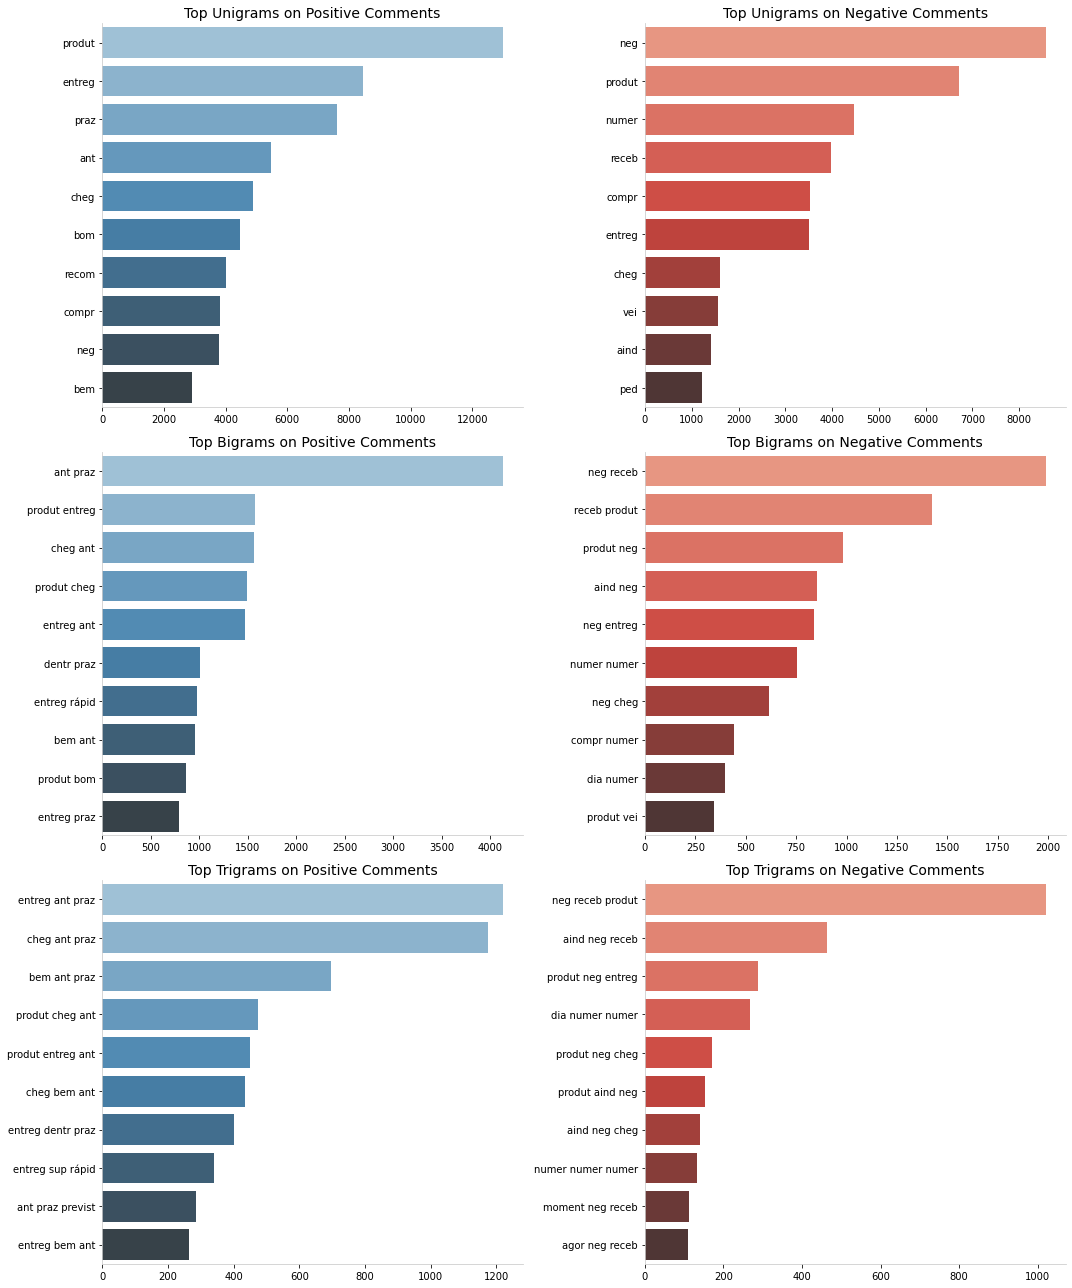

In [17]:
# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': unigrams_pos,
    'Top Unigrams on Negative Comments': unigrams_neg,
    'Top Bigrams on Positive Comments': bigrams_pos,
    'Top Bigrams on Negative Comments': bigrams_neg,
    'Top Trigrams on Positive Comments': trigrams_pos,
    'Top Trigrams on Negative Comments': trigrams_neg,
}

# Plotting the ngrams analysis
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
i, j = 0, 0
colors = ['Blues_d', 'Reds_d']
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='count', y='ngram', data=ngram_data, ax=ax, palette=colors[j])
    
    # Customizing plots
    format_spines(ax, right_border=False)
    ax.set_title(title, size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Incrementing the index
    j += 1
    if j == 2:
        j = 0
        i += 1
plt.tight_layout()
plt.show()

## Pipeline

In [18]:
# Class for regular expressions application
class ApplyRegex(BaseEstimator, TransformerMixin):
    
    def __init__(self, regex_transformers):
        self.regex_transformers = regex_transformers
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Applying all regex functions in the regex_transformers dictionary
        for regex_name, regex_function in self.regex_transformers.items():
            X = regex_function(X)
            
        return X

# Class for stopwords removal from the corpus
class StopWordsRemoval(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_stopwords):
        self.text_stopwords = text_stopwords
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stopwords_removal(comment, self.text_stopwords)) for comment in X]

# Class for apply the stemming process
class StemmingProcess(BaseEstimator, TransformerMixin):
    
    def __init__(self, stemmer):
        self.stemmer = stemmer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stemming_process(comment, self.stemmer)) for comment in X]
    
# Class for extracting features from corpus
class TextFeatureExtraction(BaseEstimator, TransformerMixin):
    
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return self.vectorizer.fit_transform(X).toarray()

In [19]:
# Defining regex transformers to be applied
regex_transformers = {
    'break_line': re_breakline,
    'hiperlinks': re_hiperlinks,
    'dates': re_dates,
    'money': re_money,
    'numbers': re_numbers,
    'negation': re_negation,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

# Defining the vectorizer to extract features from text
vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=stopwords.words('portuguese'))

# Building the Pipeline
text_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('portuguese'))),
    ('stemming', StemmingProcess(RSLPStemmer())),
    ('text_features', TextFeatureExtraction(vectorizer))
])

In [20]:
# Defining X and y 
idx_reviews = reviews_df['review_comment_message'].dropna().index
score = reviews_df['review_score'][idx_reviews].map(score_map)

# Splitting into train and test sets
X = list(reviews_df['review_comment_message'][idx_reviews].values)
y = score.apply(lambda x: 1 if x == 'positive' else 0).values

# Applying the pipeline and splitting the data
X_processed = text_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=.20, random_state=42)

# Verifying results
print(f'Length of X_train_processed: {len(X_train)} - Length of one element: {len(X_train[0])}')
print(f'Length of X_test_processed: {len(X_test)} - Length of one element: {len(X_test[0])}')

Length of X_train_processed: 32781 - Length of one element: 300
Length of X_test_processed: 8196 - Length of one element: 300


## Sentiment Classification

### ML Functions
this has to be an independent module

In [21]:
import pandas as pd
import numpy as np
import itertools
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, cross_val_predict, learning_curve
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
#import shap

from sklearn.cluster import KMeans


"""
-----------------------------------
-------- 1. CLASSIFICATION --------
     1.1 Classifiers Analysis
-----------------------------------
"""


class BinaryClassifiersAnalysis:
    """
    This class makes the work on training binary classifiers easier by bringing useful functions for training,
    purposing search on hyperparameters space, evaluating metrics and much more
    """

    def __init__(self):
        self.classifiers_info = {}

    def fit(self, classifiers, X, y, approach='', random_search=False, scoring='roc_auc', cv=5, verbose=5, n_jobs=-1):
        """
        This function receives information from classifiers to be trained, the data to be used on training and other
        parameters for fitting the model to the data.

        Parameters
        ----------
        :param classifiers: dictionary containing estimators and hyperparameters inner dict [type: dict]
        :param X: object containing features already prepared for training the model [type: np.array]
        :param y: object containing the model target variable [type: np.array]
        :param approach: string to be added on model's name as sufix for identifying purposes [type: string, default: '']
        :param random_search: guides the application of Randomized Search on training [type: bool, default: True]
        :param scoring: scoring metric to be optimized on random search [type: string, default: 'roc_auc']
        :param cv: K-folds used on random search cross-validation [type: int, default: 5]
        :param verbose: verbose param from RandomizedSearchCV [type: int, default: 5]
        :param n_jobs: n_jobs param from RandomizedSarchCV [type: int, default: -1]

        Return
        ------
        This method don't return anything but it fills some class attributes like self.classifiers_info dict

        Application
        -----------
        # Creating dictionary object for storing models information
        set_classifiers = {
            'ModelName': {
                'model': ClassifierEstimator(),
                'params': clf_dict_params
            }
        }
        trainer = BinaryClassifierAnalysis()
        trainer.fit(set_classifiers, X_train_prep, y_train, random_search=True, cv=5)
        """

        # Iterating trough every model in the dictionary of classifiers
        for model_name, model_info in classifiers.items():
            clf_key = model_name + approach
            print(f'Training model {clf_key}\n')

            # Creating an empty dict for storing model information
            self.classifiers_info[clf_key] = {}

            # Application of RandomizedSearchCV
            if random_search:
                rnd_search = RandomizedSearchCV(model_info['model'], model_info['params'], scoring=scoring, cv=cv,
                                                verbose=verbose, random_state=42, n_jobs=n_jobs)
                rnd_search.fit(X, y)

                # Saving the best estimator into the model's dict
                self.classifiers_info[clf_key]['estimator'] = rnd_search.best_estimator_
            else:
                self.classifiers_info[clf_key]['estimator'] = model_info['model'].fit(X, y)

    def compute_train_performance(self, model_name, estimator, X, y, cv=5):
        """
        This function applies cross validation to retrieve useful metrics for the classification model.
        In practice, this function would be called by another one (usually with compute_test_performance as well)

        Parameters
        ----------
        :param model_name: key-string that identifies a model at self.classifiers_info dict [type: string]
        :param estimator:
        :param X: object containing features already prepared for training the model [type: np.array]
        :param y: object containing the model target variable [type: np.array]
        :param cv: k-folds for cross validation application on training evaluation

        Return
        ------
        :return train_performance: DataFrame containing model metrics calculated using cross validation

        Application
        -----------
        # Evaluating training performance using cross-validation
        df_performances = trainer.compute_train_performance('DecisionTrees', trained_model, X_train, y_train, cv=5)
        """

        # Computing metrics using cross validation
        t0 = time.time()
        accuracy = cross_val_score(estimator, X, y, cv=cv, scoring='accuracy').mean()
        precision = cross_val_score(estimator, X, y, cv=cv, scoring='precision').mean()
        recall = cross_val_score(estimator, X, y, cv=cv, scoring='recall').mean()
        f1 = cross_val_score(estimator, X, y, cv=cv, scoring='f1').mean()

        # Probas for calculating AUC
        try:
            y_scores = cross_val_predict(estimator, X, y, cv=cv, method='decision_function')
        except:
            # Tree based models don't have 'decision_function()' method, but 'predict_proba()'
            y_probas = cross_val_predict(estimator, X, y, cv=cv, method='predict_proba')
            y_scores = y_probas[:, 1]
        auc = roc_auc_score(y, y_scores)

        # Saving scores on self.classifiers_info dictionary
        self.classifiers_info[model_name]['train_scores'] = y_scores

        # Creating a DataFrame with metrics
        t1 = time.time()
        delta_time = t1 - t0
        train_performance = {}
        train_performance['model'] = model_name
        train_performance['approach'] = f'Treino {cv} K-folds'
        train_performance['acc'] = round(accuracy, 4)
        train_performance['precision'] = round(precision, 4)
        train_performance['recall'] = round(recall, 4)
        train_performance['f1'] = round(f1, 4)
        train_performance['auc'] = round(auc, 4)
        train_performance['total_time'] = round(delta_time, 3)

        return pd.DataFrame(train_performance, index=train_performance.keys()).reset_index(drop=True).loc[:0, :]

    def compute_test_performance(self, model_name, estimator, X, y):
        """
        This function retrieves metrics from the trained model on test data.
        In practice, this function would be called by another one (usually with compute_train_performance as well)

        Parameters
        ----------
        :param model_name: key-string that identifies a model at self.classifiers_info dict [type: string]
        :param estimator:
        :param X: object containing features already prepared for training the model [type: np.array]
        :param y: object containing the model target variable [type: np.array]

        Return
        ------
        :return test_performance: DataFrame containing model metrics calculated on test data

        Application
        -----------
        # Evaluating test data performance
        df_performances = trainer.compute_test_performance('DecisionTrees', trained_model, X_train, y_train)
        """

        # Predicting data using the trained model and computing probabilities
        t0 = time.time()
        y_pred = estimator.predict(X)
        y_proba = estimator.predict_proba(X)
        y_scores = y_proba[:, 1]

        # Retrieving metrics using test data
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        auc = roc_auc_score(y, y_scores)

        # Saving probabilities on treined classifiers dictionary
        self.classifiers_info[model_name]['test_scores'] = y_scores

        # Creating a DataFrame with metrics
        t1 = time.time()
        delta_time = t1 - t0
        test_performance = {}
        test_performance['model'] = model_name
        test_performance['approach'] = f'Teste'
        test_performance['acc'] = round(accuracy, 4)
        test_performance['precision'] = round(precision, 4)
        test_performance['recall'] = round(recall, 4)
        test_performance['f1'] = round(f1, 4)
        test_performance['auc'] = round(auc, 4)
        test_performance['total_time'] = round(delta_time, 3)

        return pd.DataFrame(test_performance, index=test_performance.keys()).reset_index(drop=True).loc[:0, :]

    def evaluate_performance(self, X_train, y_train, X_test, y_test, cv=5, save=False, overwrite=True,
                             performances_filepath='model_performances.csv'):
        """
        This function centralizes the evaluating metric process by calling train and test evaluation functions.

        Parameters
        ----------
        :param X_train: training data to be used on evaluation [np.array]
        :param y_train: training target variable to be used on evaluation [type: np.array]
        :param X_test: testing data to be used on evaluation [np.array]
        :param y_test: testing target variable to be used on evaluation [type: np.array]
        :param cv: K-folds used on cross validation step [type: int, default: 5]
        :param save: flag that guides saving the final DataFrame with metrics [type: bool, default: False]
        :param overwrite: flag that guides the overwriting of a saved metrics file [type: bool, default: True]
        :param performances_filepath: path reference for saving model performances dataset [type: string,
                                                                        default: 'model_performances.csv']

        Return
        ------
        :return df_performance: DataFrame containing model metrics calculated on training and test data

        Application
        -----------
        # Evaluating performance on training and testint
        df_performance = trainer.evaluate_performance(X_train, y_train, X_test, y_test, save=True)
        """

        # Iterating over each trained classifier at classifiers_info dictionary
        df_performances = pd.DataFrame({})
        for model_name, model_info in self.classifiers_info.items():

            # Validating if the model was already trained (the key 'train_performance' will be at model_info dict if so)
            if 'train_performance' in model_info.keys():
                df_performances = df_performances.append(model_info['train_performance'])
                df_performances = df_performances.append(model_info['test_performance'])
                continue

            # Returning the estimator for calling the evaluation functions
            print(f'Evaluating model {model_name}\n')
            estimator = model_info['estimator']

            # Retrieving training and testing metrics by calling inner functions
            train_performance = self.compute_train_performance(model_name, estimator, X_train, y_train, cv=cv)
            test_performance = self.compute_test_performance(model_name, estimator, X_test, y_test)

            # Putting results on model's dictionary (classifiers_info)
            self.classifiers_info[model_name]['train_performance'] = train_performance
            self.classifiers_info[model_name]['test_performance'] = test_performance

            # Building and unique DataFrame with performances retrieved
            model_performance = train_performance.append(test_performance)
            df_performances = df_performances.append(model_performance)

            # Saving some attributes on model_info dictionary for further access
            model_data = {
                'X_train': X_train,
                'y_train': y_train,
                'X_test': X_test,
                'y_test': y_test
            }
            model_info['model_data'] = model_data

        # Saving the metrics file if applicable
        if save:
            # Adding information of measuring and execution time
            cols_performance = list(df_performances.columns)
            df_performances['anomesdia'] = datetime.now().strftime('%Y%m%d')
            df_performances['anomesdia_datetime'] = datetime.now()
            df_performances = df_performances.loc[:, ['anomesdia', 'anomesdia_datetime'] + cols_performance]

            # Validating overwriting or append on data already saved
            if overwrite:
                df_performances.to_csv(performances_filepath, index=False)
            else:
                try:
                    # If overwrite is False, tries reading existing metrics data and applying append on it
                    log_performances = pd.read_csv(performances_filepath)
                    full_performances = log_performances.append(df_performances)
                    full_performances.to_csv(performances_filepath, index=False)
                except FileNotFoundError:
                    print('Log de performances do modelo não existente no caminho especificado. Salvando apenas o atual.')
                    df_performances.to_csv(performances_filepath, index=False)

        return df_performances

    def feature_importance_analysis(self, features, specific_model=None, graph=True, ax=None, top_n=30,
                                    palette='viridis', save=False, features_filepath='features_info.csv'):
        """
        This function retrieves the feature importance from a given model. It can also build a bar chart
        for top_n most important features and plot it on the notebook.

        Paramters
        ---------
        :param features: list of model features used on training [type: list]
        :param specific_model: information that guides the returning of feature importance for a specific model*
        :param graph: flag that guides bar chart plotting at the end of execution [type: bool, default: True]
        :param ax: axis for plotting the bar chart [type: matplotlib.axes, default: None]
        :param top_n: parameter for showing up just top most important features [type: int, default: 30]
        :param palette: color configuration for feature importance bar chart [type: string, default: 'viridis']
        :param save: flag for saving the dataset returned [type: bool, default: False]
        :param features_filepath: path for saving the feature iportance dataset [type: string, default: 'features_info.csv']

        Returns
        -------
        :return: model_feature_importance: pandas DataFrame with feature importances extracted by trained models
        """

        # Iterating over each trained classifiers on classifiers_info dictionary
        feat_imp = pd.DataFrame({})
        all_feat_imp = pd.DataFrame({})
        for model_name, model_info in self.classifiers_info.items():
            # Creating a pandas DataFrame with model feature importance
            try:
                importances = model_info['estimator'].feature_importances_
            except:
                # If the given model doesn't have the feature_importances_ method, just continue for the next
                continue
            # Preparing the dataset with useful information
            feat_imp['feature'] = features
            feat_imp['importance'] = importances
            feat_imp['anomesdia'] = datetime.now().strftime('%Y%m')
            feat_imp['anomesdia_datetime'] = datetime.now()
            feat_imp.sort_values(by='importance', ascending=False, inplace=True)
            feat_imp.reset_index(drop=True, inplace=True)

            # Saving the feature iportance at model's dictionary (classifiers_info)
            self.classifiers_info[model_name]['feature_importances'] = feat_imp
            all_feat_imp = all_feat_imp.append(feat_imp)
            all_feat_imp['model'] = model_name

        # Retrieving feature importance for a specific model
        if specific_model is not None:
            try:
                model_feature_importance = self.classifiers_info[specific_model]['feature_importances']
                if graph:
                    # Plotting the bar chart
                    sns.barplot(x='importance', y='feature', data=model_feature_importance.iloc[:top_n, :],
                                ax=ax, palette=palette)
                    format_spines(ax, right_border=False)
                    ax.set_title(f'Top {top_n} {specific_model} Features mais Relevantes', size=14, color='dimgrey')

                # Saving features for a specific model
                if save:
                    model_feature_importance['model'] = specific_model
                    order_cols = ['anomesdia', 'anomesdia_datetime', 'model', 'feature', 'importance']
                    model_feature_importance = model_feature_importance.loc[:, order_cols]
                    model_feature_importance.to_csv(features_filepath, index=False)
                return model_feature_importance

            except:
                # Exception raised if the "specific_model" param doesn't match with any model's dictionary key
                print(f'Classificador {specific_model} não existente nas chaves de classificadores treinados.')
                print(f'Opções possíveis: {list(self.classifiers_info.keys())}')
                return None

        else:
            # Validating feature importance saving if not passing specific_model param
            if save:
                order_cols = ['anomesdia', 'anomedia_datetime', 'model', 'feature', 'importance']
                all_feat_imp = all_feat_imp.loc[:, order_cols]
                all_feat_imp.to_csv(features_filepath, index=False)
            return all_feat_imp

        # Non-matching param combination (it can't be possible plotting bar chart for all models)
        if graph and specific_model is None:
            print('Por favor, escolha um modelo específico para visualizar o gráfico das feature importances')
            return None

    def plot_roc_curve(self, figsize=(16, 6)):
        """
        This function iterates over each estimator in classifiers_info dictionary and plots the ROC Curve for
        each one for training (first axis) and testing data (second axis)

        Paramaters
        ----------
        :param figsize: figure size for the plot [type: tuple, default: (16, 6)]

        Returns
        -------
        This function doesn't return anything but the matplotlib plot for ROC Curve

        Application
        -----------
        trainer.plot_roc_curve()
        """

        # Creating matplotlib figure and axis for ROC Curve plot
        fig, axs = plt.subplots(ncols=2, figsize=figsize)

        # Iterating over trained models
        for model_name, model_info in self.classifiers_info.items():
            # Returning y data for the model (training and testing)
            y_train = model_info['model_data']['y_train']
            y_test = model_info['model_data']['y_test']

            # Returning scores already calculated after performance evaluation
            train_scores = model_info['train_scores']
            test_scores = model_info['test_scores']

            # Calculating false positives and true positives rate
            train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_scores)
            test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_scores)

            # Returning the auc metric for training and testing already calculated after model evaluation
            train_auc = model_info['train_performance']['auc'].values[0]
            test_auc = model_info['test_performance']['auc'].values[0]

            # Plotting graph (training data)
            plt.subplot(1, 2, 1)
            plt.plot(train_fpr, train_tpr, linewidth=2, label=f'{model_name} auc={train_auc}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.axis([-0.02, 1.02, -0.02, 1.02])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - Train Data')
            plt.legend()

            # Plotting graph (testing data)
            plt.subplot(1, 2, 2)
            plt.plot(test_fpr, test_tpr, linewidth=2, label=f'{model_name} auc={test_auc}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.axis([-0.02, 1.02, -0.02, 1.02])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - Test Data', size=12)
            plt.legend()

        plt.show()

    def custom_confusion_matrix(self, model_name, y_true, y_pred, classes, cmap, normalize=False):
        """
        This function is used for plotting and customizing a confusion matrix for a specific model. In practice,
        this function can be called by a top level one for plotting matrix for many models.

        Parameters
        ----------
        :param model_name: key reference for extracting model's estimator from classifiers_dict [type: string]
        :param y_true: label reference for the target variable [type: np.array]
        :param y_pred: array of predictions given by the respective model [type: np.array]
        :param classes: alias for classes [type: string]
        :param cmap: this parameters guides the colorway for the matrix [type: matplotlib.colormap]
        :param normalize: normalizes the entries for the matrix [type: bool, default: False]

        Returns
        -------
        :return: This functions doesn't return any object besides of plotting the confusion matrix

        Application
        -----------
        Please refer to the self.plot_confusion_matrix() function

        """

        # Returning a confusion matrix given the labels and predictions passed as args
        conf_mx = confusion_matrix(y_true, y_pred)

        # Plotando matriz
        plt.imshow(conf_mx, interpolation='nearest', cmap=cmap)
        plt.colorbar()
        tick_marks = np.arange(len(classes))

        # Customizando eixos
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        # Customizando entradas
        fmt = '.2f' if normalize else 'd'
        thresh = conf_mx.max() / 2.
        for i, j in itertools.product(range(conf_mx.shape[0]), range(conf_mx.shape[1])):
            plt.text(j, i, format(conf_mx[i, j]),
                     horizontalalignment='center',
                     color='white' if conf_mx[i, j] > thresh else 'black')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title(f'{model_name}\nConfusion Matrix', size=12)

    def plot_confusion_matrix(self, classes, normalize=False, cmap=plt.cm.Blues):
        """
        This function plots a confusion matrix for training and testing data for each classifier at
        self.classifiers_dict dictionary

        Parameters
        ----------
        :param classes: labels for the target variable [type: string]
        :param normalize: flag that guides the normalization of matrix values [type: bool, default: False]
        :param cmap: param that colorizes the matrix [type: plt.cm, default: plt.cm.Blues]

        Returns
        -------
        This function doesn't return anything but the matplotlib plot for confusion matrix
        """

        # Defining parameters for ploting
        k = 1
        nrows = len(self.classifiers_info.keys())
        fig = plt.figure(figsize=(10, nrows * 4))
        sns.set(style='white', palette='muted', color_codes=True)

        # Iterating over each classifier
        for model_name, model_info in self.classifiers_info.items():
            # Returning data from each model
            X_train = model_info['model_data']['X_train']
            y_train = model_info['model_data']['y_train']
            X_test = model_info['model_data']['X_test']
            y_test = model_info['model_data']['y_test']

            # Making predictions for training (cross validation) and testing for returning confusion matrix
            train_pred = cross_val_predict(model_info['estimator'], X_train, y_train, cv=5)
            test_pred = model_info['estimator'].predict(X_test)

            # Plotting matrix (training data)
            plt.subplot(nrows, 2, k)
            self.custom_confusion_matrix(model_name + ' Train', y_train, train_pred, classes=classes, cmap=cmap,
                                         normalize=normalize)
            k += 1

            # Plotting matrix (testing data)
            plt.subplot(nrows, 2, k)
            self.custom_confusion_matrix(model_name + ' Test', y_test, test_pred, classes=classes, cmap=plt.cm.Greens,
                                         normalize=normalize)
            k += 1

        plt.tight_layout()
        plt.show()

    def plot_learning_curve(self, model_name, ax, ylim=None, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
        """
        This function calculates and plots the learning curve for a trained model

        Parameters
        ----------
        :param model_name: Key reference for extracting an estimator from classifiers_dict dictionary [type: string]
        :param ax: axis reference for plotting the learning curve [type: matplotlib.axis]
        :param ylim: configuration of the limit on plot vertical axis [type: int, default: None]
        :param cv: k-folds used on cross validation [type: int, default: 5]
        :param n_jobs: number of cores used on retrieving the learning curve params [type: int, default: 1]
        :param train_sizes: array that guides the steps bins used on learning curve [type: np.array,
                                                                                    default:np.linspace(.1, 1.0, 10)]

        Returns
        -------
        This function doesn't return anything but the matplotlib plot for the learning curve

        Application
        -----------
        # Plotting the learning curve for a specific model
        fig, ax = plt.subplots(figsize=(16, 6))
        trainer.plot_learning_curve(model_name='LightGBM', ax=ax)
        """

        # Returning the model to be evaluated
        try:
            model = self.classifiers_info[model_name]
        except:
            print(f'Classificador {model_name} não foi treinado.')
            print(f'Opções possíveis: {list(self.classifiers_info.keys())}')
            return None

        # Returning useful data for the model
        X_train = model['model_data']['X_train']
        y_train = model['model_data']['y_train']

        # Calling the learning curve model for retrieving the scores for training and validation
        train_sizes, train_scores, val_scores = learning_curve(model['estimator'], X_train, y_train, cv=cv,
                                                               n_jobs=n_jobs, train_sizes=train_sizes)

        # Computing averages and standard deviation (training and validation)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        val_scores_mean = np.mean(val_scores, axis=1)
        val_scores_std = np.std(val_scores, axis=1)

        # Results on training data
        ax.plot(train_sizes, train_scores_mean, 'o-', color='navy', label='Training Score')
        ax.fill_between(train_sizes, (train_scores_mean - train_scores_std), (train_scores_mean + train_scores_std),
                        alpha=0.1, color='blue')

        # Results on cross validation
        ax.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Cross Val Score')
        ax.fill_between(train_sizes, (val_scores_mean - val_scores_std), (val_scores_mean + val_scores_std),
                        alpha=0.1, color='crimson')

        # Customizing graph
        ax.set_title(f'Model {model_name} - Learning Curve', size=14)
        ax.set_xlabel('Training size (m)')
        ax.set_ylabel('Score')
        ax.grid(True)
        ax.legend(loc='best')

    def plot_score_distribution(self, model_name, shade=False):
        """
        This function plots a kdeplot for training and testing data splitting by target class

        Parameters
        ----------
        :param model_name: key reference for the trained model [type: string]
        :param shade: shade param for seaborn's kdeplot [type: bool, default: False]

        Returns
        -------
        This function doesn't return anything but the matplotlib plot for the score distribution

        Application
        -----------
        # Ploting scores distribution for a model
        plot_score_distribution(model_name='LightGBM', shade=True)
        """

        # Returning the model to be evaluated
        try:
            model = self.classifiers_info[model_name]
        except:
            print(f'Classificador {model_name} não foi treinado.')
            print(f'Opções possíveis: {list(self.classifiers_info.keys())}')
            return None

        # Retrieving y array for training and testing data
        y_train = model['model_data']['y_train']
        y_test = model['model_data']['y_test']

        # Retrieving training and testing scores
        train_scores = model['train_scores']
        test_scores = model['test_scores']

        # Plotting scores distribution
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
        sns.kdeplot(train_scores[y_train == 1], ax=axs[0], label='y=1', shade=shade, color='darkslateblue')
        sns.kdeplot(train_scores[y_train == 0], ax=axs[0], label='y=0', shade=shade, color='crimson')
        sns.kdeplot(test_scores[y_test == 1], ax=axs[1], label='y=1', shade=shade, color='darkslateblue')
        sns.kdeplot(test_scores[y_test == 0], ax=axs[1], label='y=0', shade=shade, color='crimson')

        # Customizing plots
        format_spines(axs[0], right_border=False)
        format_spines(axs[1], right_border=False)
        axs[0].set_title('Score Distribution - Training Data', size=12, color='dimgrey')
        axs[1].set_title('Score Distribution - Testing Data', size=12, color='dimgrey')
        plt.suptitle(f'Score Distribution: a Probability Approach for {model_name}\n', size=14, color='black')
        plt.show()

    def plot_score_bins(self, model_name, bin_range):
        """
        This function plots a score distribution based on quantity of each class in a specific bin_range set

        Parameters
        ----------
        :param model_name: key reference for the trained model [type: string]
        :param bin_range: defines a range of splitting the bins array [type: float]

        Returns
        -------
        This function doesn't return anything but the matplotlib plot for the score bins distribution

        Application
        -----------
        # Ploting scores distribution for a model in another approach
        plot_score_bins(model_name='LightGBM', bin_range=0.1)
        """

        # Returning the model to be evaluated
        try:
            model = self.classifiers_info[model_name]
        except:
            print(f'Classificador {model_name} não foi treinado.')
            print(f'Opções possíveis: {list(self.classifiers_info.keys())}')
            return None

        # Creating the bins array
        bins = np.arange(0, 1.01, bin_range)
        bins_labels = [str(round(list(bins)[i - 1], 2)) + ' a ' + str(round(list(bins)[i], 2)) for i in range(len(bins))
                       if i > 0]

        # Retrieving the train scores and creating a DataFrame
        train_scores = model['train_scores']
        y_train = model['model_data']['y_train']
        df_train_scores = pd.DataFrame({})
        df_train_scores['scores'] = train_scores
        df_train_scores['target'] = y_train
        df_train_scores['faixa'] = pd.cut(train_scores, bins, labels=bins_labels)

        # Computing the distribution for each bin
        df_train_rate = pd.crosstab(df_train_scores['faixa'], df_train_scores['target'])
        df_train_percent = df_train_rate.div(df_train_rate.sum(1).astype(float), axis=0)

        # Retrieving the test scores and creating a DataFrame
        test_scores = model['test_scores']
        y_test = model['y_test']
        df_test_scores = pd.DataFrame({})
        df_test_scores['scores'] = test_scores
        df_test_scores['target'] = y_test
        df_test_scores['faixa'] = pd.cut(test_scores, bins, labels=bins_labels)

        # Computing the distribution for each bin
        df_test_rate = pd.crosstab(df_test_scores['faixa'], df_test_scores['target'])
        df_test_percent = df_test_rate.div(df_test_rate.sum(1).astype(float), axis=0)

        # Defining figure for plotting
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

        # Plotting the bar chart for each bin
        for df_scores, ax in zip([df_train_scores, df_test_scores], [axs[0, 0], axs[0, 1]]):
            sns.countplot(x='faixa', data=df_scores, hue='target', ax=ax, palette=['darkslateblue', 'crimson'])
            AnnotateBars(n_dec=0, color='dimgrey').vertical(ax)
            ax.legend(loc='upper right')
            format_spines(ax, right_border=False)

        # Plotting percentage for each class in each bin
        for df_percent, ax in zip([df_train_percent, df_test_percent], [axs[1, 0], axs[1, 1]]):
            df_percent.plot(kind='bar', ax=ax, stacked=True, color=['darkslateblue', 'crimson'], width=0.6)

            # Customizing plots
            for p in ax.patches:
                # Collecting params for labeling
                height = p.get_height()
                width = p.get_width()
                x = p.get_x()
                y = p.get_y()

                # Formatting params and putting into the graph
                label_text = f'{round(100 * height, 1)}%'
                label_x = x + width - 0.30
                label_y = y + height / 2
                ax.text(label_x, label_y, label_text, ha='center', va='center', color='white',
                        fontweight='bold', size=10)
            format_spines(ax, right_border=False)

        # Final definitions
        axs[0, 0].set_title('Quantity of each Class by Range - Train', size=12, color='dimgrey')
        axs[0, 1].set_title('Quantity of each Class by Range - Test', size=12, color='dimgrey')
        axs[1, 0].set_title('Percentage of each Class by Range - Train', size=12, color='dimgrey')
        axs[1, 1].set_title('Percentage of each Class by Range - Test', size=12, color='dimgrey')
        plt.suptitle(f'Score Distribution by Range - {model_name}\n', size=14, color='black')
        plt.tight_layout()
        plt.show()

    def shap_analysis(self, model_name, features):
        """
        This function brings a shap analysis for each feature into the model

        Parameters
        ----------
        :param model_name: key reference for the trained model [type: string]
        :param features: features list for the model [type: list]

        Returns
        -------
        This function doesn't return anything but the shap plot analysis

        Application
        -----------
        # Executing a shap analysis
        trainer.shap_analysis(model_name='LightGBM')
        """

        # Returning the model to be evaluated
        try:
            model = self.classifiers_info[model_name]
        except:
            print(f'Classificador {model_name} não foi treinado.')
            print(f'Opções possíveis: {list(self.classifiers_info.keys())}')
            return None

        # Retrieving training data
        X_train = model['X_train']

        # Applying shap approach
        explainer = shap.TreeExplainer(model)
        df_train = pd.DataFrame(X_train, columns=features)
        shap_values = explainer.shap_values(df_train)

        # Plotting a summary plot using shap
        shap.summary_plot(shap_values[1], df_train)


def cross_val_performance(estimator, X, y, cv=5):
    """
    This function applies cross validation to retrieve useful metrics for the classification model.
    In practice, this function would be called by another one (usually with compute_test_performance as well)

    Parameters
    ----------
    :param estimator: a trained model to be used on evaluation [type: model]
    :param X: object containing features already prepared for training the model [type: np.array]
    :param y: object containing the model target variable [type: np.array]
    :param cv: k-folds for cross validation application on training evaluation

    Return
    ------
    :return train_performance: DataFrame containing model metrics calculated using cross validation

    Application
    -----------
    # Evaluating training performance using cross-validation
    df_performances = trainer.compute_train_performance('DecisionTrees', trained_model, X_train, y_train, cv=5)
    """

    # Computing metrics using cross validation
    t0 = time.time()
    accuracy = cross_val_score(estimator, X, y, cv=cv, scoring='accuracy').mean()
    precision = cross_val_score(estimator, X, y, cv=cv, scoring='precision').mean()
    recall = cross_val_score(estimator, X, y, cv=cv, scoring='recall').mean()
    f1 = cross_val_score(estimator, X, y, cv=cv, scoring='f1').mean()

    # Probas for calculating AUC
    try:
        y_scores = cross_val_predict(estimator, X, y, cv=cv, method='decision_function')
    except:
        # Tree based models don't have 'decision_function()' method, but 'predict_proba()'
        y_probas = cross_val_predict(estimator, X, y, cv=cv, method='predict_proba')
        y_scores = y_probas[:, 1]
    auc = roc_auc_score(y, y_scores)

    # Creating a DataFrame with metrics
    t1 = time.time()
    delta_time = t1 - t0
    train_performance = {}
    train_performance['model'] = estimator.__class__.__name__
    train_performance['approach'] = 'Final Model'
    train_performance['acc'] = round(accuracy, 4)
    train_performance['precision'] = round(precision, 4)
    train_performance['recall'] = round(recall, 4)
    train_performance['f1'] = round(f1, 4)
    train_performance['auc'] = round(auc, 4)
    train_performance['total_time'] = round(delta_time, 3)
    df_performance = pd.DataFrame(train_performance, index=train_performance.keys()).reset_index(drop=True).loc[:0, :]

    # Adding information of measuring and execution time
    cols_performance = list(df_performance.columns)
    df_performance['anomesdia'] = datetime.now().strftime('%Y%m%d')
    df_performance['anomesdia_datetime'] = datetime.now()
    df_performance = df_performance.loc[:, ['anomesdia', 'anomesdia_datetime'] + cols_performance]

    return df_performance
    

"""
-----------------------------------
---------- 2. CLUSTERING ----------
-----------------------------------
"""


def elbow_method_kmeans(df, K_min, K_max, figsize=(16, 6)):
    """
    This function applies the elbow method using K-means clustering algorithm in order to select the best number of
    k clusters for the task

    Parameters
    ----------
    :param df: DataFrame with data to be clustered [type: pd.DataFrame]
    :param K_min: minimum index of K to be evaluated on elbow method [type: int]
    :param K_max: maximum index of K to be evaluated on elbow method [type: int]
    :param figsize: figure dimension for the matplotlib plot [type: tuple, default: (16, 5)]

    Returns
    -------
    :return: This function doesn't return anything but the elbow method plot for further analysis

    Application
    -----------
    # Looking at the elbow graphic for selection the best k number of clusters
    elbow_method_kmeans(df=data, K_min=1, K_max=8)
    """

    # Training differente K-Means models for each number of flusters in range K_min, K_max
    square_dist = []
    for k in range(K_min, K_max+1):
        km = KMeans(n_clusters=k)
        km.fit(df)
        # Computing and keeping the square distances for each model configuration
        square_dist.append(km.inertia_)

    # Plotting elbow analysis
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x=range(K_min, K_max), y=square_dist, color='cornflowerblue', marker='o')

    # Customizing the graph
    format_spines(ax, right_border=False)
    ax.set_title('Elbow Method - KMeans Model', size=14, color='dimgrey')
    ax.set_xlabel('Total of Clusters (K)')
    ax.set_ylabel('Euclidian Distance')
    plt.show()


def plot_kmeans_clusters_2d(df, k_means, figsize=(16, 6), cmap='viridis'):
    """
    This function plots and customizes a 2D result from a trained K-means algorithm

    Parameters
    ----------
    :param df: DataFrame with the two columns used on training the K-means algorithm [type: pd.DataFrame]
    :param kmeans: trained K-means model [type: model]
    :param figsize: figure dimension for the plot [type: tuple, default: (16, 6)]
    :param cmap: param for coloring the plot with a specific palette [type: string, default: 'viridis]

    Returns
    -------
    :return: This function doesn't return anything but the K-means algorithm plot

    Application
    -----------
    # Visualizing the kmeans result on a trained 2D model data
    model = KMeans(n_clusters=3)
    cluster_data = df.loc[:, two_columns_list]
    k_means.fit(cluster_data)
    plot_kmeans_clusters_2d(cluster_data, model)
    """

    # Computing y_kmeans and centers
    y_kmeans = k_means.predict(df)
    centers = k_means.cluster_centers_

    # REtrieving values and defining layout
    variaveis = df.columns
    X = df.values
    sns.set(style='white', palette='muted', color_codes=True)

    # Plotting the scatterplot chart
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap=cmap)
    ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

    # Customizing the graph
    ax.set_title(f'K_Means aplicado entre {variaveis[0].upper()} e {variaveis[1].upper()}', size=14, color='dimgrey')
    format_spines(ax, right_border=False)
    ax.set_xlabel(variaveis[0])
    ax.set_ylabel(variaveis[1])
    plt.show()

### Model Training

In [22]:
# Logistic Regression hyperparameters
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Setting up the classifiers
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    }
}

In [23]:
# Creating an object and training the classifiers
clf_tool = BinaryClassifiersAnalysis()
clf_tool.fit(set_classifiers, X_train, y_train, random_search=True, scoring='accuracy')

Training model LogisticRegression

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END C=3.747368421052632, class_weight=None, penalty=l1, random_state=42, solver=liblinear;, score=0.888 total time=   3.0s
[CV 2/5] END C=3.747368421052632, class_weight=None, penalty=l1, random_state=42, solver=liblinear;, score=0.884 total time=   3.0s
[CV 3/5] END C=3.747368421052632, class_weight=None, penalty=l1, random_state=42, solver=liblinear;, score=0.884 total time=   3.2s
[CV 4/5] END C=3.747368421052632, class_weight=None, penalty=l1, random_state=42, solver=liblinear;, score=0.891 total time=   3.3s
[CV 2/5] END C=0.1, class_weight=balanced, penalty=l1, random_state=42, solver=liblinear;, score=0.856 total time=   1.7s
[CV 1/5] END C=0.1, class_weight=balanced, penalty=l1, random_state=42, solver=liblinear;, score=0.863 total time=   1.9s
[CV 3/5] END C=0.1, class_weight=balanced, penalty=l1, random_state=42, solver=liblinear;, score=0.869 total time=   2.0s
[CV 5/5] E

/mnt/c/Users/TOSHIBA/Desktop/Platzi/Master/data_modeling/brazilian-e-commerce/Data_analysis/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.835 total time=   6.8s
[CV 2/5] END ..................................., score=0.843 total time=   7.2s
[CV 4/5] END ..................................., score=0.835 total time=   7.3s
[CV 3/5] END ..................................., score=0.835 total time=   7.5s
[CV 5/5] END ..................................., score=0.832 total time=   1.9s


In [25]:
# Evaluating metrics
df_performances = clf_tool.evaluate_performance(X_train, y_train, X_test, y_test, cv=5)
df_performances.reset_index(drop=True).style.background_gradient(cmap='Blues')

/tmp/ipykernel_14611/740861747.py:228: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_performances = df_performances.append(model_info['train_performance'])
/tmp/ipykernel_14611/740861747.py:229: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_performances = df_performances.append(model_info['test_performance'])
/tmp/ipykernel_14611/740861747.py:229: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_performances = df_performances.append(model_info['test_performance'])


,model,approach,acc,precision,recall,f1,auc,total_time
0,LogisticRegression,Treino 5 K-folds,0.886200,0.922400,0.922500,0.922400,0.943500,18.487000
1,LogisticRegression,Teste,0.885600,0.924500,0.919900,0.922200,0.944400,0.150000
2,Naive Bayes,Treino 5 K-folds,0.836100,0.946100,0.823600,0.880500,0.884300,46.533000
3,Naive Bayes,Teste,0.833900,0.948000,0.819900,0.879300,0.887900,0.406000


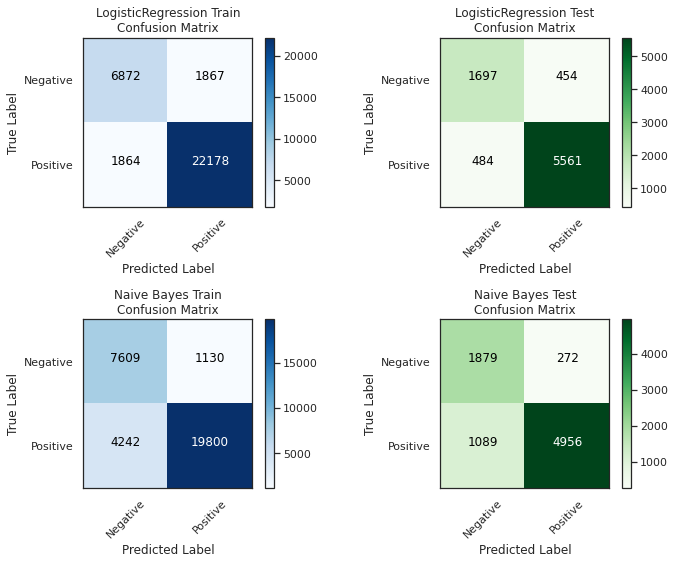

In [26]:
clf_tool.plot_confusion_matrix(classes=['Negative', 'Positive'])

## Model Appliance

In [27]:
# Defining a function to plot the sentiment of a given phrase
def sentiment_analysis(text, pipeline, vectorizer, model):
    """
    Args
    -----------
    text: text string / phrase / review comment to be analysed [type: string]
    pipeline: text prep pipeline built for preparing the corpus [type: sklearn.Pipeline]
    model: classification model trained to recognize positive and negative sentiment [type: model]
    """
    
    # Applying the pipeline
    if type(text) is not list:
        text = [text]
    text_prep = pipeline.fit_transform(text)
    matrix = vectorizer.transform(text_prep)
    
    # Predicting sentiment
    pred = model.predict(matrix)
    proba = model.predict_proba(matrix)
    
    # Plotting the sentiment and its score
    fig, ax = plt.subplots(figsize=(5, 3))
    if pred[0] == 1:
        text = 'Positive'
        class_proba = 100 * round(proba[0][1], 2)
        color = 'seagreen'
    else:
        text = 'Negative'
        class_proba = 100 * round(proba[0][0], 2)
        color = 'crimson'
    ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
    ax.text(0.5, 0.20, str(class_proba) + '%', fontsize=14, ha='center')
    ax.axis('off')
    ax.set_title('Sentiment Analysis', fontsize=14)
    plt.show()

In [28]:
# Defining transformers for preparing the text input
model = clf_tool.classifiers_info['LogisticRegression']['estimator']
prod_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('portuguese'))),
    ('stemming', StemmingProcess(RSLPStemmer()))
])
vectorizer = text_pipeline.named_steps['text_features'].vectorizer

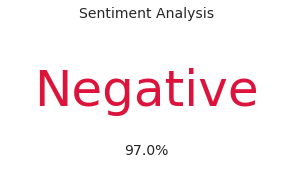

In [83]:
comment = 'Péssimo !! 👎🏽👎🏽 Não compro nessa loja, a entrega atrasou e custou muito dinheiro! 😡'
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

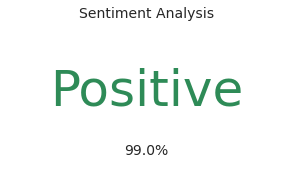

In [30]:
comment = 'Adorei e realmente cumpriu as expectativas. valor barato e Maravilhoso 💙'
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

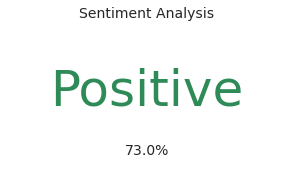

In [31]:
comment = 'Não sei gostei do produto. O custo foi barato mas veio com defeito. Se der sorte, vale a pena'
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

## Apply NLP model to External data

### Custom Transformers

In [38]:
"""
This script is responsible for allocating custom function and classes to be used on a day to day work in python.
The applications can be to simple optimized data reading or a custom transformer put into a ML pipeline.

--- SUMMARY ---

1. Custom Functions
2. Custom Pipelines Transformers
    2.1 Pre Processing Pipelines
    2.2 Processing Pipelines

"""

# Importing libraries
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split


"""
-----------------------------------
------- 1. CUSTOM FUNCTIONS -------
-----------------------------------
"""


def import_data(path, sep=',', optimized=True, n_lines=50, encoding='utf-8', usecols=None, verbose=True):
    """
    This functions applies a csv reading in an optimized way, converting data types (float64 to float32 and
    int 64 to int32), reducing script memory usage.

    Parameters
    ----------
    :param path: path reference for importing the data [type: string]
    :param sep: separator parameter for read_csv() method [type: string, default: ',']
    :param optimized: boolean flag for reading data in an optimized way [type: bool, default: True]
    :param n_lines: number of lines read during the data type optimization [type: int, default: 50]
    :param encoding: encoding param for read_csv() method [type: string, default: 'utf-8']
    :param verbose: the verbose arg allow communication between steps [type: bool, default: True]
    :param usecols: columns to read - set None to read all the columns [type: list, default: None]

    Return
    ------
    :return: df: file after the preparation steps [type: pd.DataFrame]

    Application
    -----------
    # Reading the data and applying a data type conversion for optimizing the memory usage
    df = import_data(filepath, optimized=True, n_lines=100)
    """

    # Validating the optimized flag for optimizing memory usage
    if optimized:
        # Reading only the first rows of the data
        df_raw = pd.read_csv(path, sep=sep, nrows=n_lines, encoding=encoding, usecols=usecols)
        start_mem = df_raw.memory_usage().sum() / 1024 ** 2

        # Columns were the optimization is applicable
        float64_cols = [col for col, dtype in df_raw.dtypes.items() if dtype == 'float64']
        int64_cols = [col for col, dtype in df_raw.dtypes.items() if dtype == 'int64']
        total_opt = len(float64_cols) + len(int64_cols)
        if verbose:
            print(f'This dataset has {df_raw.shape[1]} columns, which {total_opt} is/are applicable to optimization.\n')

        # Optimizing data types: float64 to float32
        for col in float64_cols:
            df_raw[col] = df_raw[col].astype('float32')

        # Optimizing data types: int64 to int32
        for col in int64_cols:
            df_raw[col] = df_raw[col].astype('int32')

        # Looking at memory reduction
        if verbose:
            print('----------------------------------------------------')
            print(f'Memory usage ({n_lines} lines): {start_mem:.4f} MB')
            end_mem = df_raw.memory_usage().sum() / 1024 ** 2
            print(f'Memory usage after optimization ({n_lines} lines): {end_mem:.4f} MB')
            print('----------------------------------------------------')
            mem_reduction = 100 * (1 - (end_mem / start_mem))
            print(f'\nReduction of {mem_reduction:.2f}% on memory usage\n')

        # Creating an object with new dtypes
        dtypes = df_raw.dtypes
        col_names = dtypes.index
        types = [dtype.name for dtype in dtypes.values]
        column_types = dict(zip(col_names, types))

        # Trying to read the dataset with new types
        try:
            return pd.read_csv(path, sep=sep, dtype=column_types, encoding=encoding, usecols=usecols)
        except ValueError as e1:
            # Error cach during data reading with new data types
            print(f'ValueError on data reading: {e1}')
            print('The dataset will be read without optimization types.')
            return pd.read_csv(path, sep=sep, encoding=encoding, usecols=usecols)
    else:
        # Reading the data without optimization
        return pd.read_csv(path, sep=sep, encoding=encoding, usecols=usecols)


def split_cat_num_data(df):
    """
    This functions receives a DataFrame object and extracts numerical and categorical features from it

    Parameters
    ----------
    :param df: DataFrame object where feature split would be extracted [type: pd.DataFrame]

    Return
    ------
    :return: num_attribs, cat_attribs: lists with numerical and categorical features [type: list]

    Application
    -----------
    # Extracting numerical and categorical features for a given DataFrame
    num_cols, cat_cols = split_cat_num_data(df)
    """

    # Splitting data attributes by data type
    num_attribs = [col for col, dtype in df.dtypes.items() if dtype != 'object']
    cat_attribs = [col for col, dtype in df.dtypes.items() if dtype == 'object']

    return num_attribs, cat_attribs


def calc_working_days(date_series1, date_series2, convert=True):
    """
    This functions receives two date series as args and calculates the working days between each of its rows.

    Parameters
    ----------
    :param date_series1: first date series to be used on working days calculation [type: pd.Series]
    :param date_series2: second date series to subtract the first one [type: pd.Series]
    :param convert: flag that guides the series conversions in datetime objects [type: bool, default: True]

    Return
    ------
    :return: wd_list: list with working days calculations between two date series

    Application
    -----------
    # Calculating the working days between two date series
    working_days = calc_working_days(df['purchase_date'], df['delivered_date'], convert=True)
    """

    # Auxiliar function for threating exceptions during the np.busday_count() function
    def handle_working_day_calc(d1, d2):
        try:
            date_diff = np.busday_count(d1, d2)
            return date_diff
        except:
            return np.NaN

    # Applying conversion on series in datetime data
    if convert:
        date_series1 = pd.to_datetime(date_series1).values.astype('datetime64[D]')
        date_series2 = pd.to_datetime(date_series2).values.astype('datetime64[D]')

    # Building a list with working days calculations between the two dates
    wd_list = [handle_working_day_calc(d1, d2) for d1, d2 in zip(date_series1, date_series2)]

    return wd_list


def indices_of_top_k(arr, k):
    """
    This function selects the top k entries in an array based on its indices

    Parameters
    ----------
    :param arr: numpy array (in practice we will feed it with model feature importance array) [type: np.array]
    :param k: top features integer definition [type: int]

    Return
    ------
    :return: sorted array with filtered input array based on k entries

    Application
    -----------

    """
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])


"""
-----------------------------------
----- 2. CUSTOM TRANSFORMERS ------
   2.1 Pre Processing Pipelines
-----------------------------------
"""


class ColsFormatting(BaseEstimator, TransformerMixin):
    """
    This class applies lower(), strip() and replace() method on a pandas DataFrame object.
    It's not necessary to pass anything as args.

    Return
    ------
    :return: df: pandas DataFrame after cols formatting [type: pd.DataFrame]

    Application
    -----------
    cols_formatter = ColsFormatting()
    df_custom = cols_formatter.fit_transform(df_old)
    """

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        df.columns = [col.lower().strip().replace(' ', '_') for col in df.columns]
        return df


class FeatureSelection(BaseEstimator, TransformerMixin):
    """
    This class filters a dataset based on a set of features passed as argument.

    Parameters
    ----------
    :param features: set of features to be selected on a DataFrame [type: list]

    Return
    ------
    :return: df: pandas DataFrame after filtering attributes [type: pd.DataFrame]

    Application
    -----------
    selector = FeatureSelection(features=model_features)
    df_filtered = selector.fit_transform(df)
    """

    def __init__(self, features):
        self.features = features

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        return df[self.features]


class TargetDefinition(BaseEstimator, TransformerMixin):
    """
    This class transform a categorical target column into a numerical one base on a positive_class

    Parameters
    ----------
    :param target_col: reference for the target column on the dataset [type: string]
    :param pos_class: entry reference for positive class in the new target [type: string]
    :param new_target_name: name of the new column created after the target mapping [type: string, default: 'target]

    Return
    ------
    :return: df: pandas DataFrame after target mapping [pd.DataFrame]

    Application
    -----------
    target_prep = TargetDefinition(target_col='class_target', pos_class='Some Category', new_target_name='target')
    df = target_prep.fit_transform(df)
    """

    def __init__(self, target_col, pos_class, new_target_name='target'):
        self.target_col = target_col
        self.pos_class = pos_class
        self.new_target_name = new_target_name

        # Sanity check: new_target_name may differ from target_col
        if self.target_col == self.new_target_name:
            print('[WARNING]')
            print(f'New target column named {self.new_target_name} must differ from raw one named {self.target_col}')

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        # Applying the new target rule based on positive class
        df[self.new_target_name] = df[self.target_col].apply(lambda x: 1 if x == self.pos_class else 0)

        # Dropping the old target column
        return df.drop(self.target_col, axis=1)


class DropDuplicates(BaseEstimator, TransformerMixin):
    """
    This class filters a dataset based on a set of features passed as argument.
    It's not necessary to pass anything as args.

    Return
    ------
    :return: df: pandas DataFrame dropping duplicates [type: pd.DataFrame]

    Application
    -----------
    dup_dropper = DropDuplicates()
    df_nodup = dup_dropper.fit_transform(df)
    """

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        return df.drop_duplicates()


class SplitData(BaseEstimator, TransformerMixin):
    """
    This class helps splitting data into training and testing and it can be used at the end of a pre_processing pipe.
    In practice, the class applies the train_test_split() function from sklearn.model_selection module.

    Parameters
    ----------
    :param target: reference of the target feature on the dataset [type: string]
    :param test_size: test_size param of train_test_split() function [type: float, default: .20]
    :param random_state: random_state param of train_test_split() function [type: int, default: 42]

    X_: attribute associated with the features dataset before splitting [1]
    y_: attribute associated with the target array before splitting [1]
        [1] The X_ and y_ attributes are initialized right before splitting and can be retrieved later in the script.

    Return
    ------
    :return: X_train: DataFrame for training data [type: pd.DataFrame]
             X_test: DataFrame for testing data [type: pd.DataFrame]
             y_train: array for training target data [type: np.array]
             y_test: array for testing target data [type: np.array]

    Application
    -----------
    splitter = SplitData(target='target')
    X_train, X_test, y_train, y_test = splitter.fit_transform(df)
    """

    def __init__(self, target, test_size=.20, random_state=42):
        self.target = target
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        # Returning X and y attributes (those can be retrieved in the future)
        self.X_ = df.drop(self.target, axis=1)
        self.y_ = df[self.target].values

        return train_test_split(self.X_, self.y_, test_size=self.test_size, random_state=self.random_state)


"""
-----------------------------------
----- 2. CUSTOM TRANSFORMERS ------
    2.2 Preparation Pipelines
-----------------------------------
"""


class DummiesEncoding(BaseEstimator, TransformerMixin):
    """
    This class applies the encoding on categorical data using pandas get_dummies() method. It also retrieves the
    features after the encoding so it can be used further on the script

    Parameters
    ----------
    :param dummy_na: flag that guides the encoding of NaN values on categorical features [type: bool, default: True]

    Return
    ------
    :return: X_dum: Dataframe object (with categorical features) after encoding [type: pd.DataFrame]

    Application
    -----------
    encoder = DummiesEncoding(dummy_na=True)
    X_encoded = encoder.fit_transform(df[cat_features])
    """

    def __init__(self, dummy_na=True):
        self.dummy_na = dummy_na

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        # Saving features into class attribute
        self.cat_features_ori = list(X.columns)

        # Applying encoding with pandas get_dummies()
        X_cat_dum = pd.get_dummies(X, dummy_na=self.dummy_na)

        # Joining datasets and dropping original columns before encoding
        X_dum = X.join(X_cat_dum)
        X_dum = X_dum.drop(self.cat_features_ori, axis=1)

        # Retrieving features after encoding
        self.features_after_encoding = list(X_dum.columns)

        return X_dum


class FillNullData(BaseEstimator, TransformerMixin):
    """
    This class fills null data. It's possible to select just some attributes to be filled with different values

    Parameters
    ----------
    :param cols_to_fill: columns to be filled. Leave None if all the columns will be filled [type: list, default: None]
    :param value_fill: value to be filled on the columns [type: int, default: 0]

    Return
    ------
    :return: X: DataFrame object with NaN data filled [type: pd.DataFrame]

    Application
    -----------
    filler = FillNullData(cols_to_fill=['colA', 'colB', 'colC'], value_fill=-999)
    X_filled = filler.fit_transform(X)
    """

    def __init__(self, cols_to_fill=None, value_fill=0):
        self.cols_to_fill = cols_to_fill
        self.value_fill = value_fill

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Filling null data according to passed args
        if self.cols_to_fill is not None:
            X[self.cols_to_fill] = X[self.cols_to_fill].fillna(value=self.value_fill)
            return X
        else:
            return X.fillna(value=self.value_fill)


class DropNullData(BaseEstimator, TransformerMixin):
    """
    This class drops null data. It's possible to select just some attributes to be filled with different values

    Parameters
    ----------
    :param cols_dropna: columns to be filled. Leave None if all the columns will be filled [type: list, default: None]

    Return
    ------
    :return: X: DataFrame object with NaN data filled [type: pd.DataFrame]

    Application
    -----------
    null_dropper = DropNulldata(cols_to_fill=['colA', 'colB', 'colC'], value_fill=-999)
    X = null_dropper.fit_transform(X)
    """

    def __init__(self, cols_dropna=None):
        self.cols_dropna = cols_dropna

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Filling null data according to passed args
        if self.cols_dropna is not None:
            X[self.cols_dropna] = X[self.cols_dropna].dropna()
            return X
        else:
            return X.dropna()


class TopFeatureSelector(BaseEstimator, TransformerMixin):
    """
    This class selects the top k most important features from a trained model

    Parameters
    ----------
    :param feature_importance: array with feature importance given by a trained model [np.array]
    :param k: integer that defines the top features to be filtered from the array [type: int]

    Return
    ------
    :return: pandas DataFrame object filtered by the k important features [pd.DataFrame]

    Application
    -----------
    feature_selector = TopFeatureSelector(feature_importance, k=10)
    X_selected = feature_selector.fit_transform(X)
    """

    def __init__(self, feature_importance, k):
        self.feature_importance = feature_importance
        self.k = k

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[:, indices_of_top_k(self.feature_importance, self.k)]

### Load Data

In [40]:
df_ml = import_data('datasets/external_data.csv')
df_ml.drop('Unnamed: 0', axis=1, inplace=True)
df_ml.rename(columns= {'comment':'review_comment_message', 'score':'review_score'}, inplace=True)
print('Dataset Shape: ', df_ml.shape)

This dataset has 3 columns, which 2 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0013 MB
Memory usage after optimization (50 lines): 0.0009 MB
----------------------------------------------------

Reduction of 30.12% on memory usage

Dataset Shape:  (61572, 2)


In [101]:
comment = ['Não sei gostei do produto. O custo foi barato mas veio com defeito. Se der sorte, vale a pena']

In [102]:
text_prep = prod_pipeline.fit_transform(comment)
matrix = vectorizer.transform(text_prep)

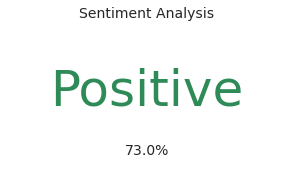

In [96]:
sentiment_analysis(comment, prod_pipeline, vectorizer, model)

In [105]:
pred = model.predict_proba(matrix)

In [106]:
pred

array([[0.26678763, 0.73321237]])

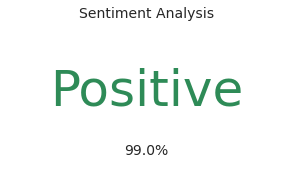

In [49]:
sentiment_analysis(comment,  pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

### General Sentiment Analysis

In [ ]:
sent_anls = []

for i in range(len(df_ml)):
    text = [df_ml['review_comment_message'][i]]
    try:
        comment_prep = prod_pipeline.fit_transform(text)
        matrix = vectorizer.transform(comment_prep)
        prediction = model.predict(matrix)
        sent_anls.append(prediction[0])
    
    except Exception as e:
        print(f"key {i}: error {e}")
        

In [111]:
sent_dict = {
    'sentiment': sent_anls,
    'sentiment_label': [('positive' if x ==1 else "negative") for x in sent_anls]
}

sent_df = pd.DataFrame(sent_dict)

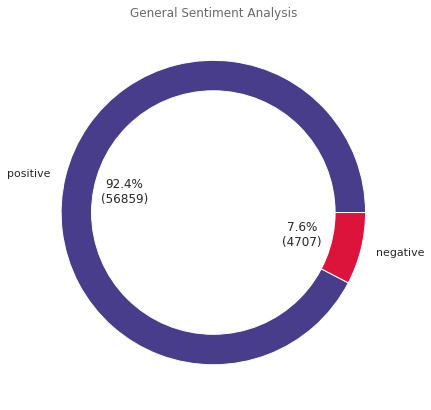

In [112]:
fig, ax = plt.subplots(figsize=(7, 7))
donut_plot(sent_df.query('sentiment_label in ("positive", "negative")'), 'sentiment_label', 
           label_names=sent_df.query('sentiment_label in ("positive", "negative")')['sentiment_label'].value_counts().index,
           ax=ax, colors=['darkslateblue', 'crimson'])
ax.set_title("General Sentiment Analysis")
plt.show()

### Category Analysis

### Functions

In [118]:
TARGET_COL = 'target'

class ColumnMapping(BaseEstimator, TransformerMixin):
    """
    This class applies the map() function into a DataFrame for transforming a columns given a mapping dictionary

    Parameters
    ----------
    :param old_col_name: name of the columns where mapping will be applied [type: string]
    :param mapping_dict: python dictionary with key/value mapping [type: dict]
    :param new_col_name: name of the new column resulted by mapping [type: string, default: 'target]
    :param drop: flag that guides the dropping of the old_target_name column [type: bool, default: True]

    Returns
    -------
    :return X: pandas DataFrame object after mapping application [type: pd.DataFrame]

    Application
    -----------
    # Transforming a DataFrame column given a mapping dictionary
    mapper = ColumnMapping(old_col_name='col_1', mapping_dict=dictionary, new_col_name='col_2', drop=True)
    df_mapped = mapper.fit_transform(df)
    """

    def __init__(self, old_col_name, mapping_dict, new_col_name='target', drop=True):
        self.old_col_name = old_col_name
        self.mapping_dict = mapping_dict
        self.new_col_name = new_col_name
        self.drop = drop

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Applying mapping
        X[self.new_col_name] = X[self.old_col_name].map(self.mapping_dict)

        # Dropping the old columns (if applicable)
        if self.drop:
            X.drop(self.old_col_name, axis=1, inplace=True)

        return X

def read_prep_data(path):
    
    df = import_data(path, verbose=False)
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df.rename(columns= {'comment':'review_comment_message', 'score':'review_score'}, inplace=True)    
    df_prep = initial_prep_pipeline.fit_transform(df)
    df_prep.reset_index(inplace=True)
    df_prep.drop('index', axis=1, inplace=True)

    return df_prep


def nlp_predic(data):
    sent_anls = []

    for i in range(len(data)):
        text = [df_ml['review_comment_message'][i]]
        try:
            comment_prep = prod_pipeline.fit_transform(text)
            matrix = vectorizer.transform(comment_prep)
            prediction = model.predict(matrix)
            sent_anls.append(prediction[0])
        
        except Exception as e:
            print(f"key {i}: error {e}")

        sent_dict = {
        'sentiment': sent_anls,
        'sentiment_label': [('positive' if x ==1 else "negative") for x in sent_anls]
    }
    
    return pd.DataFrame(sent_dict)

initial_prep_pipeline = Pipeline([
    ('mapper', ColumnMapping(old_col_name='review_score', mapping_dict=score_map, new_col_name=TARGET_COL)),
    ('null_dropper', DropNullData()),
    ('dup_dropper', DropDuplicates())
])


### Analysis

In [119]:
import json

with open('../Scraping/categories/brazil.json', 'r') as f:
    category = json.load(f)
    f.close()

files = [key for key in category]

In [120]:
# Algorithm to map graphs

slots = []
i = 0     
while i < 4:
    j = 0
    while j < 5:
        slots.append((i,j))
        j+=1
    i+=1


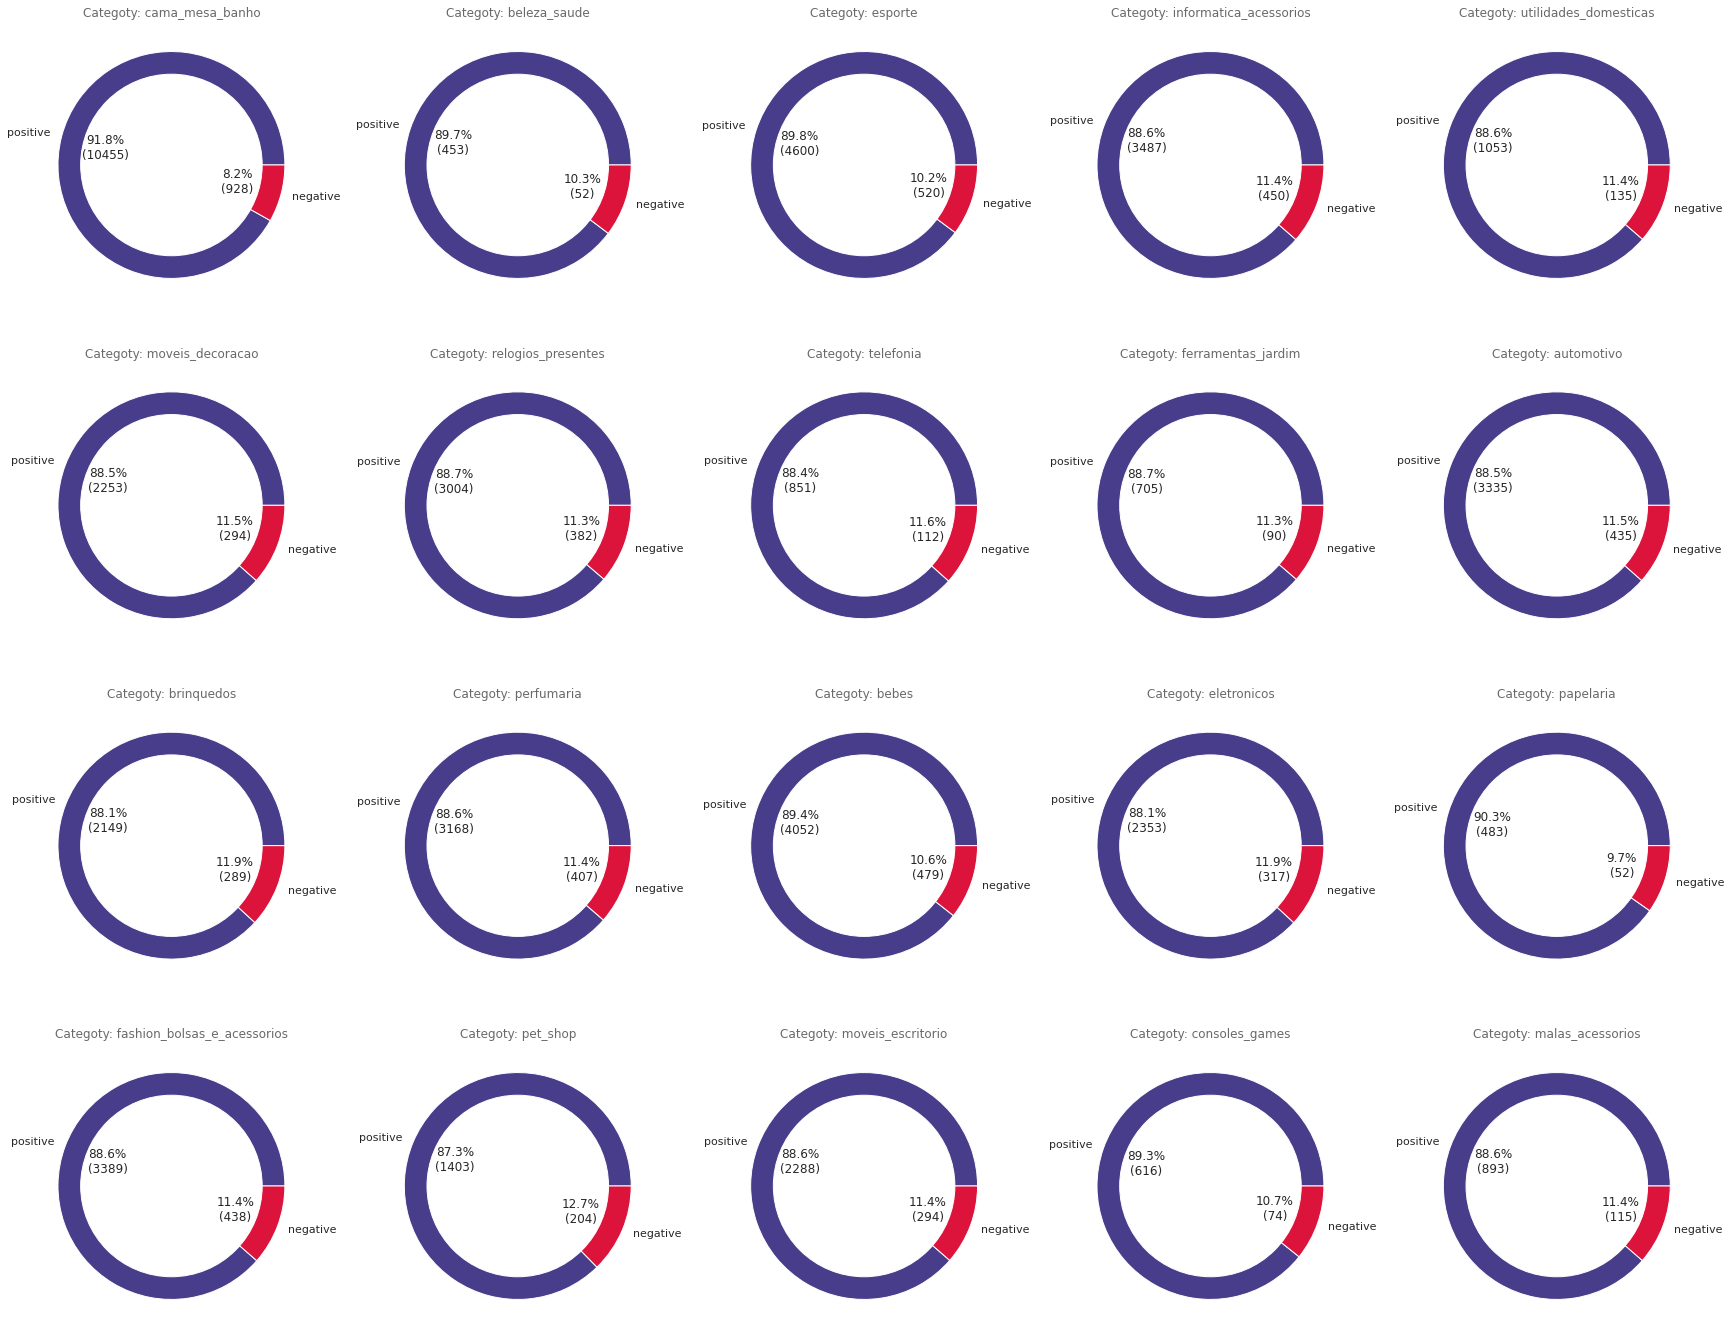

In [121]:
fig, axs = plt.subplots(4, 5, figsize=(30, 24))
for i, file in enumerate(files):
    path = '../Scraping/External_data/{}.csv'.format(file)
    data = read_prep_data(path)
    prediction = nlp_predic(data)

    donut_plot(prediction.query('sentiment_label in ("positive", "negative")'), 'sentiment_label', 
        label_names=prediction.query('sentiment_label in ("positive", "negative")')['sentiment_label'].value_counts().index,
        ax=axs[slots[i]], colors=['darkslateblue', 'crimson'])
    axs[slots[i]].set_title('Categoty: {}'.format(file))
    
plt.show()
